### Objective
- This notebook shows exploratory data analysis of the toxic comment classiifcation data set
- These are the analyses done:
    1. Missing & Duplicated Values Check
    2. Class distribution
    3. Multi-labels/class
    4. Correlation analysis among classes
    5. Comment content analysis using wordcloud
    6. Comment content analysis using calculated features

### Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud
import nltk
# nltk.download('stopwords') #uncomment if required
from nltk.corpus import stopwords

import scipy.stats as ss
import numpy as np
from itertools import combinations

In [2]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
%matplotlib inline

### Read data

In [3]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
print(train_df.shape, test_df.shape)

(159571, 8) (153164, 2)


#### 1. Missing & Duplicate Values Check
- There are no missing values observed for train and test data
- There is also no duplicated ids in both datasets

In [14]:
# Check train data for missing and duplicate values
print(f'Train data: {train_df.shape}\n')
print(f'No. of duplicated ids: {train_df["id"].duplicated().sum()}')
print(f'No. of missing values')
print(train_df.isna().sum())
train_df.head()

Train data: (159571, 8)

No. of duplicated ids: 0
No. of missing values
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
# Check test data for missing and duplicate values
print(f'Test data: {test_df.shape}\n')
print(f'No. of duplicated ids: {test_df["id"].duplicated().sum()}')
print(test_df.isna().sum())
test_df.head()

Test data: (153164, 2)

No. of duplicated ids: 0
id              0
comment_text    0
dtype: int64


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


#### 2. Class distribution 
- There is a severe class imbalance in the train dataset
- There also appears to be more class labels (178444) that train data records (159571)
- This is likely a consequence of 1 comment having multiple labels

In [28]:
class_labels = train_df.columns.tolist()[2:]
class_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
non_toxic_count = len(train_df.iloc[:, 2:].sum(axis=1).loc[lambda x: x==0])
print(f'Number of non-toxic comments: {non_toxic_count} ({round(non_toxic_count/len(train_df)*100, 2)}%)')

class_df = train_df.iloc[:, 2:].sum()
class_df = class_df.append(pd.Series([non_toxic_count], index=['non-toxic']))
class_df = class_df.sort_values(ascending=False)
print(f'Total number of comments: {len(train_df)}')
print(f'Total number of labels: {class_df.sum()}')

Number of non-toxic comments: 143346 (89.83%)
Total number of comments: 159571
Total number of labels: 178444


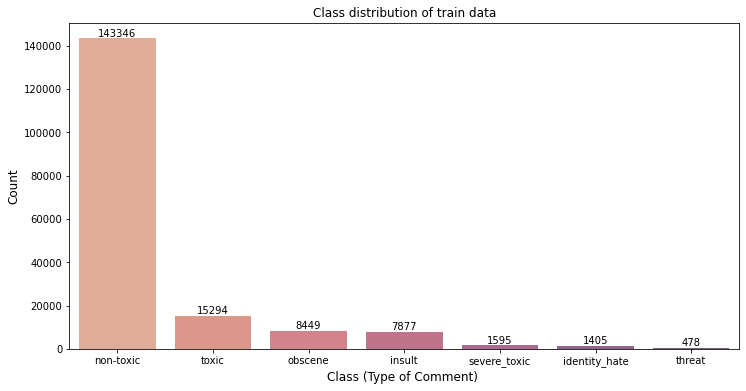

In [7]:
# Plot class distribution
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_df.index, y=class_df.values, alpha=0.8, palette='flare')
plt.title('Class distribution of train data')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class (Type of Comment) ', fontsize=12)

# Adding the text labels
rects = ax.patches
labels = class_df.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### 3. Multi-labels
- Excluding non-toxic comments, most comments have 1 label
- There are 31 comments that have a label of 1 for each type of toxic comment

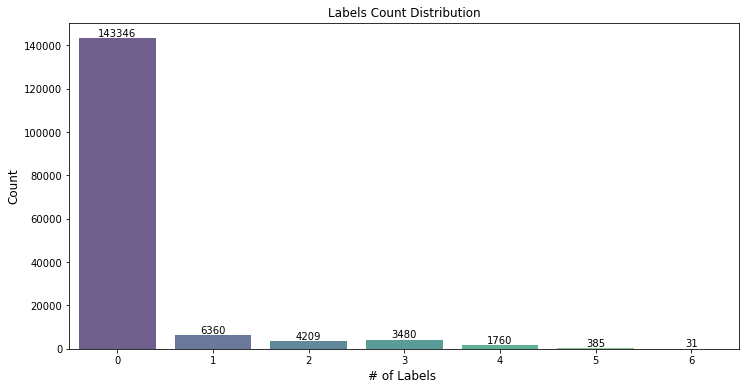

In [8]:
multi_label_df = train_df.iloc[:, 2:].sum(axis=1).value_counts()
#plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=multi_label_df.index, y=multi_label_df.values, alpha=0.8, palette='viridis')

plt.title("Labels Count Distribution")
plt.ylabel('Count', fontsize=12)
plt.xlabel('# of Labels ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = multi_label_df.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

#### 4. Correlation
- Here we use Cramer's correlation to compute correlation between a pair of categorical variables
- Correlation between threat and other types of comments are generally low (<0.2)
- Highest correlation is observed between obscene and insult categories at 0.741

In [10]:
def cramers_corrected_stat(confusion_matrix):
    '''Reference: https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
    
    Parameters
    ----------
    confusion_matrix: pandas dataframe
        generated by pd.crosstab of a pair of categorical variables
    '''
    
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [11]:
for col1, col2 in combinations(train_df.columns[2:], 2):
    conf_matrix_df = pd.crosstab(train_df[col1], train_df[col2])
    corr = cramers_corrected_stat(conf_matrix_df)
    print(f"Crammer's correlation between {col1} and {col2}: {corr}")

Crammer's correlation between toxic and severe_toxic: 0.30850290540548614
Crammer's correlation between toxic and obscene: 0.6764644772231891
Crammer's correlation between toxic and threat: 0.15684415261524137
Crammer's correlation between toxic and insult: 0.6474661802275932
Crammer's correlation between toxic and identity_hate: 0.26588449189333063
Crammer's correlation between severe_toxic and obscene: 0.402867277063916
Crammer's correlation between severe_toxic and threat: 0.12299982239401752
Crammer's correlation between severe_toxic and insult: 0.37565458087765363
Crammer's correlation between severe_toxic and identity_hate: 0.20124809672050067
Crammer's correlation between obscene and threat: 0.1409011841641497
Crammer's correlation between obscene and insult: 0.7412059371540987
Crammer's correlation between obscene and identity_hate: 0.2867070544132799
Crammer's correlation between threat and insult: 0.14973727415030422
Crammer's correlation between threat and identity_hate: 0.1

In [60]:
# 24012, 2143
idx = np.random.choice(list(range(len(train_df))))
print(idx)
print(train_df['comment_text'].iloc[idx])

24012
"
Who are you calling, a ""troll""? ;) 98.207.236.113  "


In [53]:
idx = np.random.choice(list(range(len(train_df))))
print(idx)
print(train_df['comment_text'].iloc[idx])

2143
fuck you 

Muthafucka ,  you jerk you scum lowlife loser !! hehe hahah188.23.179.183


#### 5. Wordcloud
- Here each wordcloud shows top 2000 commonly occuring words (excluding stopwords) in each category/label
- Size of word is proportional to the frequency of word appearing in the comments

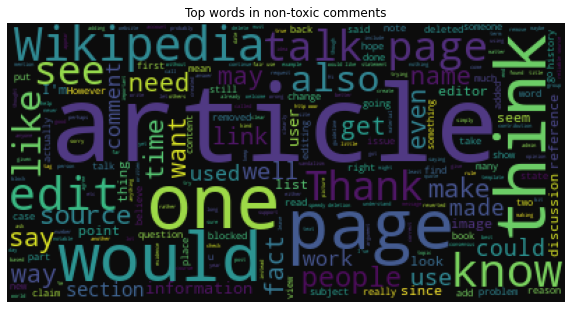

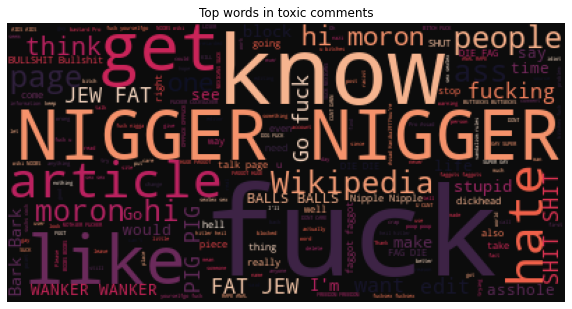

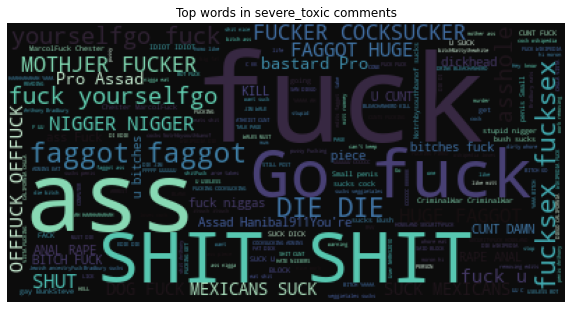

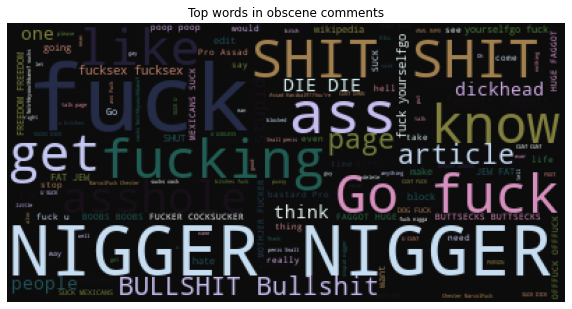

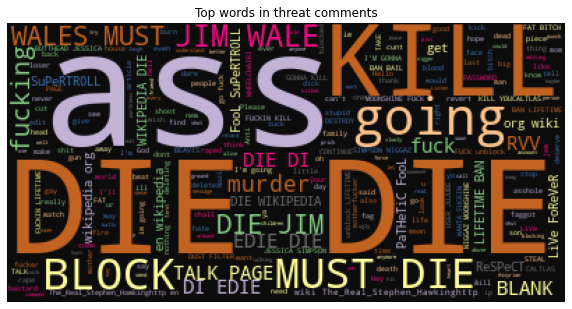

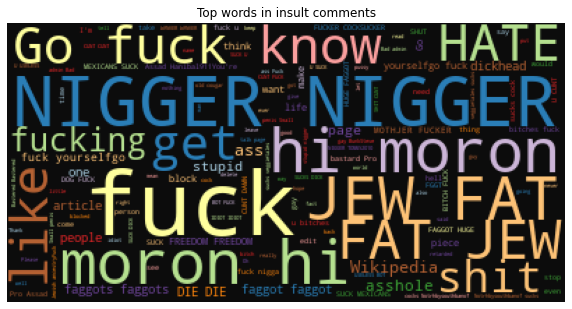

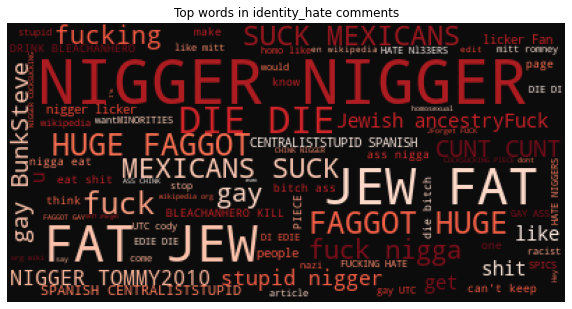

In [30]:
eng_stopwords = stopwords.words('english')
max_words = 2000
colormaps = ['viridis', 'rocket', 'mako', 'cubehelix', 'Accent', 'Paired_r', 'Reds_r']

for idx, (col, cmap) in enumerate(zip(train_df.columns[1:], colormaps), 1):
    if idx==1:
        # Non-toxic comments
        sub_df = train_df[train_df.apply(
            lambda row: sum(row[col] for col in row.index[2:])==0,
            axis=1)].copy()
        col = 'non-toxic'
    else:
        sub_df = train_df[train_df[col]==1].copy()
    comments = sub_df['comment_text'].values
    wc = WordCloud(background_color='black', max_words=max_words, stopwords=eng_stopwords)
    wc.generate(' '.join(comments))

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title(f'Top words in {col} comments', fontsize=12)
    plt.imshow(wc.recolor(colormap=cmap , random_state=1), alpha=0.95)

plt.show()

#### 6. Comments content

In [78]:
%%time
fea_df = train_df.copy()
fea_df['char_count'] = fea_df['comment_text'].apply(len)
fea_df['word_count'] = fea_df['comment_text'].apply(lambda x: len(x.split()))
fea_df['sent_count'] = fea_df['comment_text'].apply(lambda x: len(x.split('\n')))
fea_df['unique_word_count'] = fea_df['comment_text'].apply(lambda x: len(set(x.split())))
fea_df['unique_word_perc'] = fea_df['unique_word_count'] / fea_df['word_count']
fea_df['upper_word_count'] = fea_df['comment_text'].apply(lambda x: len([xi for xi in x.split() if xi.isupper()]))
fea_df['upper_word_perc'] = fea_df['upper_word_count'] / fea_df['word_count']
fea_df['bad?'] = fea_df.apply(
    lambda row: sum(row[col] for col in row.index[2:8])!=0, axis=1)

# Cutoff counts
for fea in ['char_count', 'word_count', 'sent_count']:
    cutoff = np.round(fea_df[fea].quantile(0.9), -1)
    fea_new = f'{fea}2'
    fea_df[fea_new] = fea_df[fea].apply(lambda x: cutoff if x>=cutoff else x)
print(fea_df.shape)

(159571, 19)
Wall time: 20.8 s


##### 1. Does length of comment affect toxicity?
- Here we look at length from 3 measures, character, word and sentence count
- There appears to be a limitation placed on comments with a maximum character count of 5000
- From all 3 measures of length, there does not appear to be a strong correlation between length of comment and whether or not a comment would be toxic in nature

In [83]:
fea_df[['char_count', 'word_count', 'sent_count']].describe()

,char_count,word_count,sent_count
count,159571.000000,159571.000000,159571.00000
mean,394.073221,67.273527,3.52074
std,590.720282,99.230702,5.96225
min,6.000000,1.000000,1.00000
25%,96.000000,17.000000,1.00000
50%,205.000000,36.000000,2.00000
75%,435.000000,75.000000,3.00000
max,5000.000000,1411.000000,313.00000


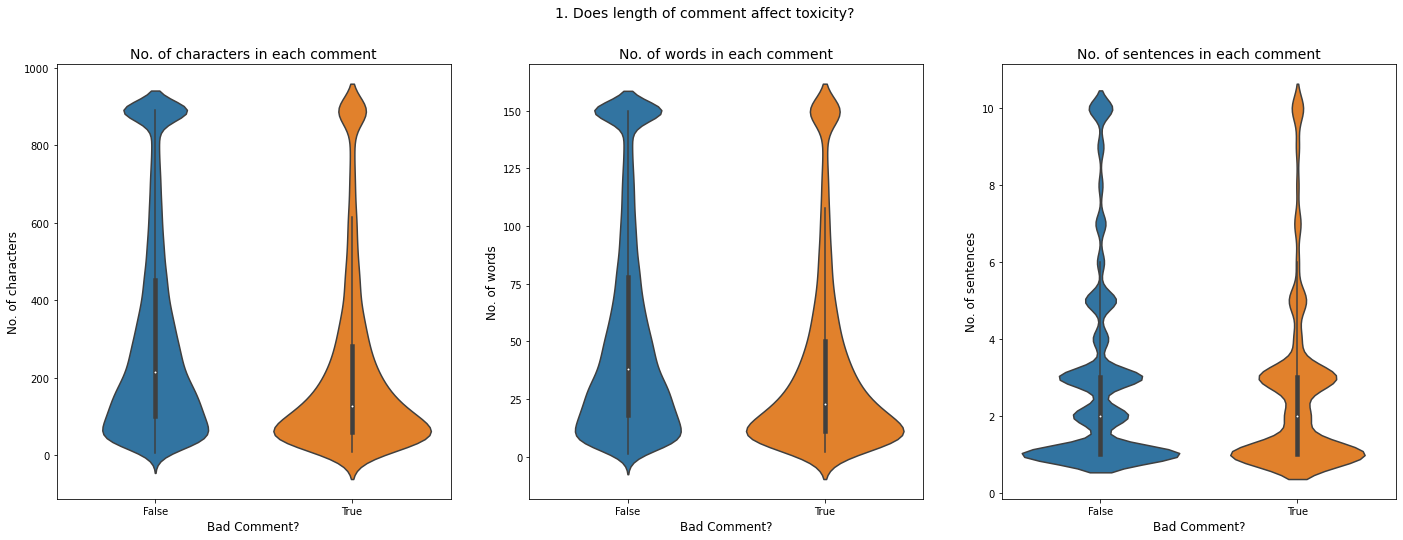

In [96]:
plt.figure(figsize=(24, 8))
plt.suptitle('Does length of comment affect toxicity?', fontsize=14)

# Characters
plt.subplot(131)
sns.violinplot(y='char_count2', x='bad?', data=fea_df, split=True)
plt.xlabel('Bad Comment?', fontsize=12)
plt.ylabel('Character count', fontsize=12)
plt.title("Character count per comment", fontsize=14)

# Words
plt.subplot(132)
sns.violinplot(y='word_count2', x='bad?', data=fea_df, split=True)
plt.xlabel('Bad Comment?', fontsize=12)
plt.ylabel('Word count', fontsize=12)
plt.title("Word count per comment", fontsize=14)

# Sentences
plt.subplot(133)
sns.violinplot(y='sent_count2', x='bad?', data=fea_df, split=True)
plt.xlabel('Bad Comment?', fontsize=12)
plt.ylabel('Sentence count', fontsize=12)
plt.title("Sentence count per comment", fontsize=14)

plt.show()

##### 2. Do unique words affect toxicity?
- With reference to the left subplot below, the distribution of unique words across 'Non-toxic' and 'Bad' comments are quite similar
- An exception is observed at low % of unique words, where we observe a slight bump for 'Bad' comments
- This signifies that there is a larger proportion of comments where text is repeated many times and not meaningful a.k.a spam

##### 3. Do uppercase words affect toxicity?
- With reference to the right subplot below, the distribution of uppercase words across 'Non-toxic' and 'Bad' comments are similar in that majority of the comments have 20% or less uppercase words
- There is however a bump observed from at high % of uppercase words for 'Bad' comments not seen for 'Non-toxic' comments

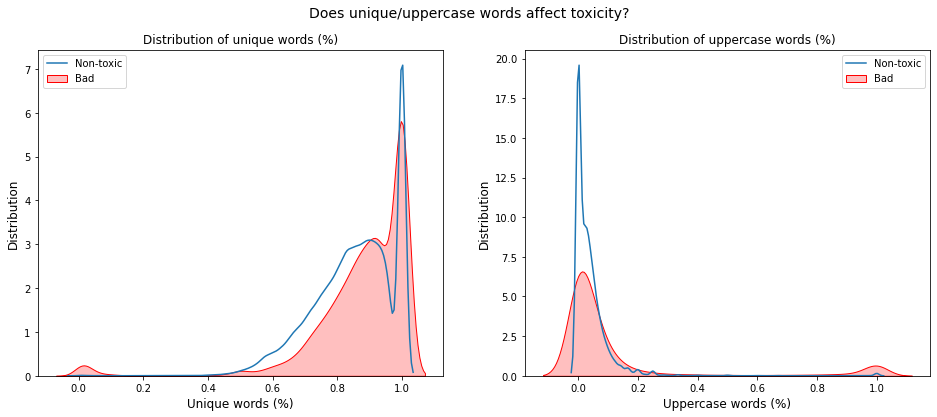

In [95]:
plt.figure(figsize=(16, 6))
plt.suptitle('Does unique/uppercase words affect toxicity?', fontsize=14)
plt.subplot(121)
ax=sns.kdeplot(fea_df.loc[fea_df['bad?']==True, 'unique_word_perc'], label="Bad", shade=True, color='r')
ax=sns.kdeplot(fea_df.loc[fea_df['bad?']==False, 'unique_word_perc'], label="Non-toxic")
plt.legend()
plt.title('Distribution of unique words (%)')
plt.xlabel('Unique words (%)', fontsize=12)
plt.ylabel('Distribution', fontsize=12)

plt.subplot(122)
ax=sns.kdeplot(fea_df.loc[fea_df['bad?']==True, 'upper_word_perc'], label="Bad", shade=True, color='r')
ax=sns.kdeplot(fea_df.loc[fea_df['bad?']==False, 'upper_word_perc'], label="Non-toxic")
plt.legend()
plt.title('Distribution of uppercase words (%)')
plt.xlabel('Uppercase words (%)', fontsize=12)
plt.ylabel('Distribution', fontsize=12)

plt.show()